---
title: "Supplementary notebook for the night light paper"
date: "2025-10-02"
author: "Krisna Gupta"
---

## Introduction

This is the notebook file to replicate our macroeconometrics approach. This notebook does not contain the `blackmarblepy` application. Source data is from `blackmarblepy` for nightlight, and [BPS](https://www.bps.go.id/id/statistics-table/2/NTQwIzI=/-seri-2010--4--laju-pertumbuhan--y-on-y--pdrb-atas-dasar-harga-konstan-menurut-pengeluaran--2010-100---persen-.html). If you happens to find any issues, you can find Krisna via krisna@dewanekonomi.go.id

You will see the following sections in this notebook:

1. Real GDP and quarterly night light index (NTL) graph;
2. OLS and residuals;
3. ADF test and Johansen Cointegration test;
4. VECM graph;
5. VAR graph; and
6. ARDL graph.

We do those steps for both quarterly dataset and growth dataset.

We only print the regression summary for a panel results that are best fit.

Note that you're going to need Stata to run the VAR regression. I somehow cannot get the VARMAX from statsmodels to converge unfortunately.

## some Packages

In [1]:
import pandas as pd
from pandas.tseries.offsets import QuarterEnd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ardl import ARDL
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from statsmodels.tsa.ardl import ardl_select_order
pd.options.display.max_seq_items = 4000 ## This is only for cosmetics.

## Growth Regression

### The GDP and night light growth dataset
Turn on the last line of the first codeblock to see the dataframe

In [2]:
## Data prep
### Creating data
ntl=pd.read_csv('ntl_monthly_avg_2012-2024.csv')
gdp=pd.read_excel('GDP_YoY_Quarterly_12_24.xlsx')

### Make time index
ntl.Date=pd.to_datetime(ntl['Date'])
ntl['qtr']=ntl['Date'].dt.quarter
ntl['year']=ntl['Date'].dt.year
### Averaging the radiance into quarterly, make it yoy quarterly growth
ntl=ntl.groupby(['year','qtr'])['NTL_Radiance'].mean().reset_index()
ntl['Date']=pd.date_range(start='2012-01-01', periods=len(ntl), freq='QE')
ntl=ntl[['Date','NTL_Radiance']]
ntl['g']=(gdp['Real GDP YoY Growth Indonesia'])
ntl['ntlg']=(ntl['NTL_Radiance'])
ntl['NTL_Radiancelag'] = ntl['NTL_Radiance'].shift(4)
ntl['ntlg'] = ((ntl['NTL_Radiance'] - ntl['NTL_Radiancelag']) / ntl['NTL_Radiancelag']) * 100
### Creating dummy quarterly and dummy covid
ntl['q1']=np.where(ntl['Date'].dt.quarter==1,1,0)
ntl['q2']=np.where(ntl['Date'].dt.quarter==2,1,0)
ntl['q3']=np.where(ntl['Date'].dt.quarter==3,1,0)
ntl['q4']=np.where(ntl['Date'].dt.quarter==4,1,0)
ntl['covid']=np.where((ntl['Date'].dt.year>=2020) & (ntl['Date'].dt.year<=2022),1,0)
ntl['scar']=np.where((ntl['Date'].dt.year>=2020) ,1,0)
### Back to making time index
ntl=ntl.dropna().reset_index(drop=True)
ntl['qtr']=ntl['Date'].dt.quarter
ntl['year']=ntl['Date'].dt.year
ntl['qqq']= ntl['year'].astype(str)+'q' + ntl['qtr'].astype(str) ## This is for Stata time index for tsset.
ntl=ntl.set_index('Date')
ntl=ntl.asfreq('QE-DEC')
#ntlm=ntlm[['g','ntlg']]

### Creating dummy quarterly and dummy covid

## OLS-ing
mod=sm.OLS(ntl['g'], sm.add_constant(ntl['ntlg'])).fit()
ntl['resid']=mod.resid
ntl['ols']=mod.predict()
#ntl

### Plot the growth dataset

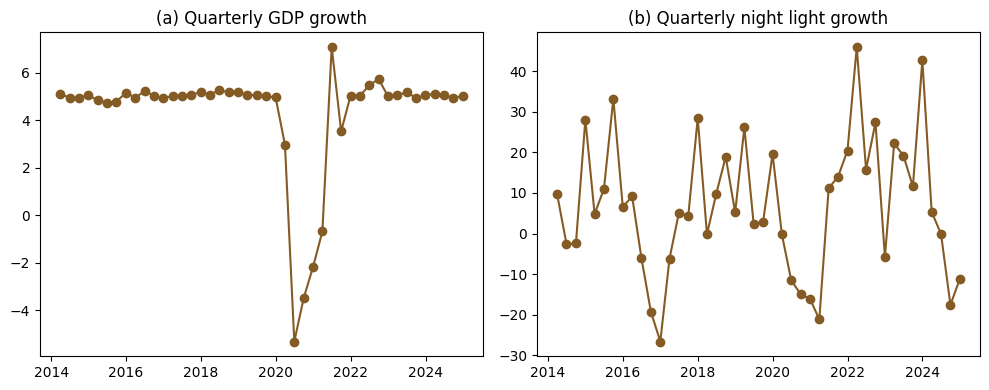

In [3]:
# Plotting GDP Growth and Night light growth side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ntlm=ntl[4:]
ax1.plot(ntlm['g'],color='#845B24',marker='o', linestyle='-')
ax1.set_title('(a) Quarterly GDP growth')

ax2.plot(ntlm['ntlg'], linestyle='-', color='#845B24',marker='o')
ax2.set_title('(b) Quarterly night light growth')

plt.tight_layout()
plt.savefig("fig/fig.png")
plt.show()


### OLS and residuals

                            OLS Regression Results                            
Dep. Variable:                      g   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     8.126
Date:                Wed, 01 Oct 2025   Prob (F-statistic):            0.00651
Time:                        22:02:59   Log-Likelihood:                -104.61
No. Observations:                  48   AIC:                             213.2
Df Residuals:                      46   BIC:                             217.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0069      0.345     11.617      0.0

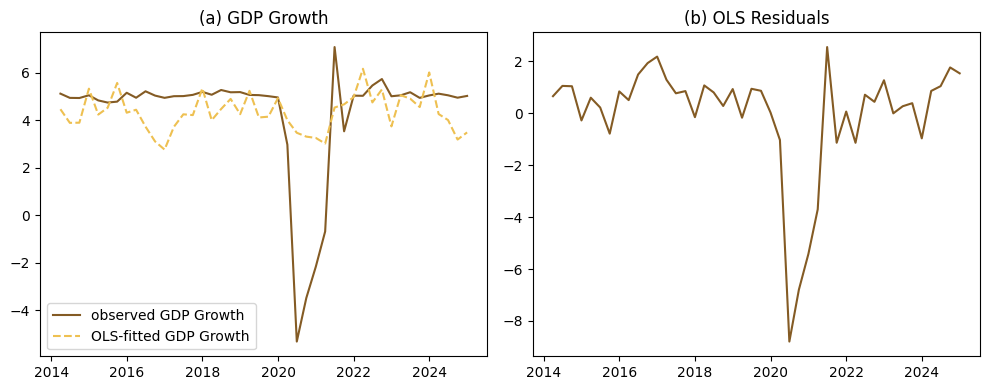

In [4]:
## OLS results and plotting residuals
ntl=ntlm
print(mod.summary())
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.plot(ntlm['g'],color='#845B24',linestyle="-",label="observed GDP Growth")
ax1.plot(ntlm['ols'],color='#EEC051',linestyle="--",label="OLS-fitted GDP Growth")
ax1.set_title('(a) GDP Growth')
ax1.legend()

ax2.plot(ntlm['resid'], linestyle='-', color='#845B24')
ax2.set_title('(b) OLS Residuals')

plt.tight_layout()
plt.savefig("fig/ols.png") # Turn off to not save, or change file name to save in your preferred location
plt.show()


### ADF test

In [5]:
## ADF Test for g, ntlg and OLS residuals
def adf_test(series, name=""):
    """
    Perform ADF test and print results
    """
    result = adfuller(series.dropna(), autolag="BIC")
    print(f"ADF Test for {name}")
    print(f"  Test Statistic : {result[0]:.4f}")
    print(f"  p-value        : {result[1]:.4f}")
    print(f"  #Lags Used     : {result[2]}")
    print(f"  #Observations  : {result[3]}")
    for key, value in result[4].items():
        print(f"   Critical Value {key} : {value:.4f}")
    if result[1] <= 0.05:
        print(f"  ==> {name} is stationary\n (reject H0 of unit root)\n")
    else:
        print(f"  ==> {name} is non-stationary\n (fail to reject H0)\n")

# Run ADF tests for both series
adf_test(ntlm["g"], "GDP YoY Growth")
adf_test(ntlm["ntlg"], "NTL YoY Growth")
adf_test(ntlm["resid"], "OLS Residuals")


ADF Test for GDP YoY Growth
  Test Statistic : -2.7478
  p-value        : 0.0661
  #Lags Used     : 0
  #Observations  : 43
   Critical Value 1% : -3.5925
   Critical Value 5% : -2.9315
   Critical Value 10% : -2.6041
  ==> GDP YoY Growth is non-stationary
 (fail to reject H0)

ADF Test for NTL YoY Growth
  Test Statistic : -4.2533
  p-value        : 0.0005
  #Lags Used     : 0
  #Observations  : 43
   Critical Value 1% : -3.5925
   Critical Value 5% : -2.9315
   Critical Value 10% : -2.6041
  ==> NTL YoY Growth is stationary
 (reject H0 of unit root)

ADF Test for OLS Residuals
  Test Statistic : -2.9893
  p-value        : 0.0359
  #Lags Used     : 0
  #Observations  : 43
   Critical Value 1% : -3.5925
   Critical Value 5% : -2.9315
   Critical Value 10% : -2.6041
  ==> OLS Residuals is stationary
 (reject H0 of unit root)



### Johansen Cointegration test

In [6]:

# Select optimal lag order
ntlm=ntl[['g','ntlg']]
lag_order = select_order(ntlm.asfreq('QE-DEC'), maxlags=12, deterministic="ci")
print(lag_order.summary())

# Select cointegration rank
coint_rank = select_coint_rank(ntlm.asfreq('QE-DEC'), det_order=0, k_ar_diff=lag_order.bic)
print(coint_rank.summary())

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        7.167      7.537*      1300.*       7.288
1        7.384       7.939       1627.       7.565
2        7.552       8.292       1950.       7.793
3        7.303       8.228       1557.       7.604
4        7.103       8.214       1324.       7.465
5        7.182       8.477       1513.       7.604
6        7.367       8.847       1972.       7.849
7        7.216       8.882       1896.       7.759
8        7.469       9.320       2854.       8.072
9        7.035       9.070       2303.       7.698
10       6.595       8.815       2040.       7.318
11       6.339       8.745       2570.       7.123
12      5.159*       7.750       1815.      6.004*
--------------------------------------------------
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------

### VECM with growth dataset

Note that I save the graph in a folder called `fig`. Please create the folder first before running the code. If you're not planning to save the graph, you can comment out the `plt.savefig` line.

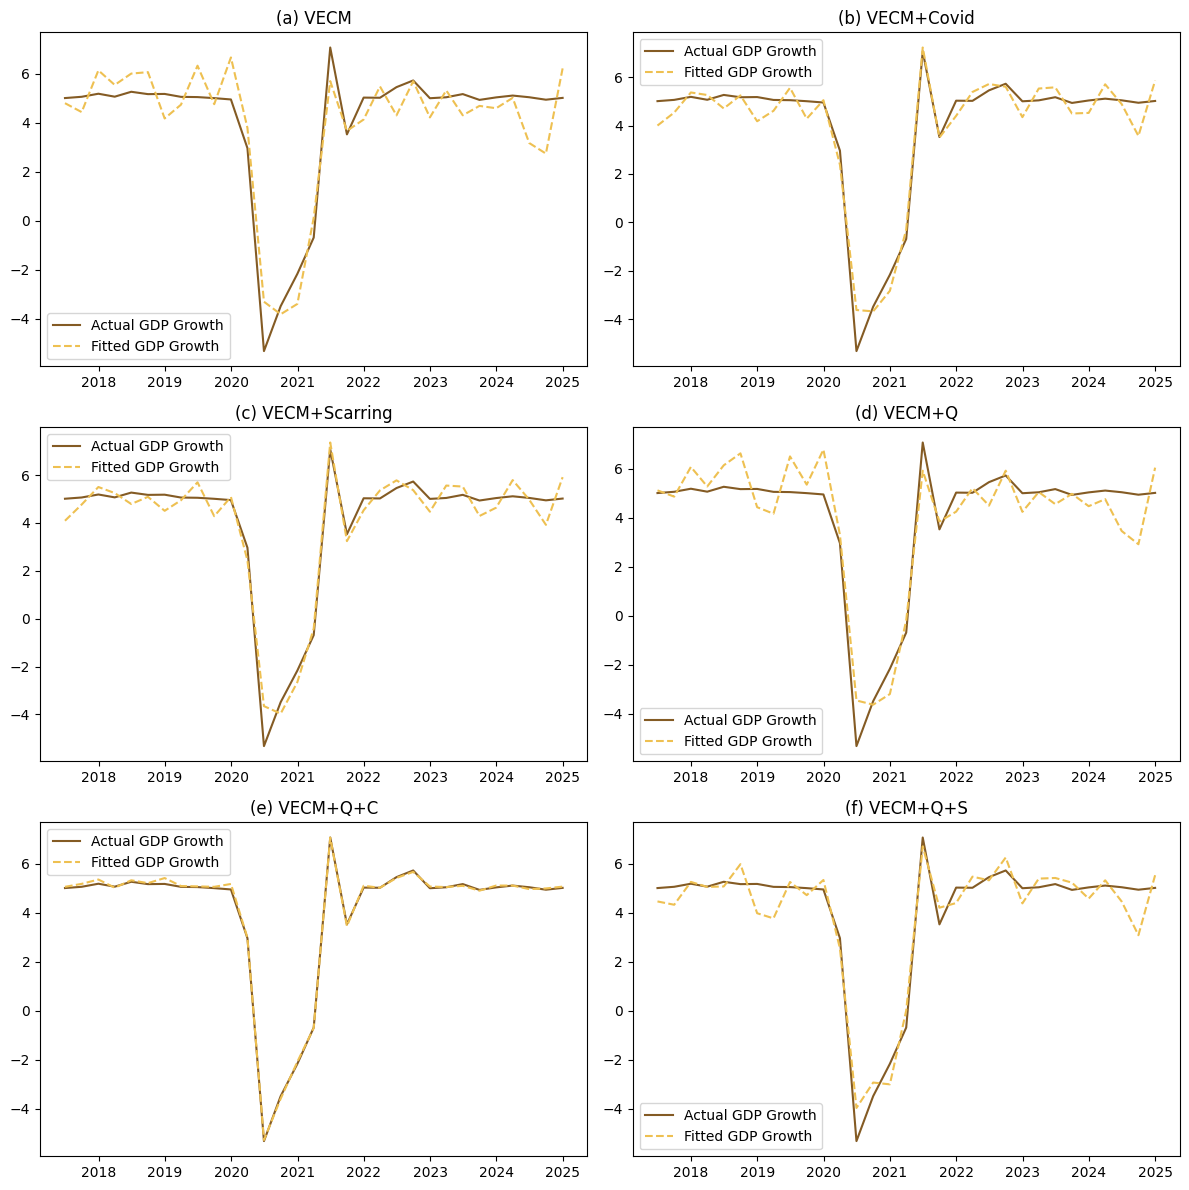

In [7]:
en=ntl[['g','ntlg']]
exc=ntl[['covid']]
exs=ntl[['scar']]
exq=ntl[['q1','q2','q3']]
exqc=ntl[['q1','q2','q3','covid']]
exqs=ntl[['q1','q2','q3','scar']]

lag=lag_order.aic

ve = VECM(en,k_ar_diff=lag, coint_rank=1, deterministic="ci").fit()
vec = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exc,deterministic="ci").fit()
ves = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exs,deterministic="ci").fit()
veq = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exq,deterministic="ci").fit()
veqc = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exqc,deterministic="ci").fit()
veqs = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exqs,deterministic="ci").fit()

models = {'fve': ve, 'fvec': vec,'fves': ves, 'fveq': veq,'fveqc': veqc, 'fveqs': veqs}
results = {}

for name, model in models.items():
    fitted = pd.DataFrame(model.fittedvalues, columns=en.columns)
    fitted.index = pd.date_range(end='2024-12-31', periods=31, freq='QE')
    merged = pd.merge(en, fitted, left_index=True, right_index=True, suffixes=('', f'_fitted'))
    results[name] = merged


fig, ax = plt.subplots(3,2,figsize=(12, 12))

ax[0,0].plot(results['fve']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[0,0].plot(results['fve']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[0,0].set_title('(a) VECM')
ax[0,0].legend()

ax[0,1].plot(results['fvec']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[0,1].plot(results['fvec']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[0,1].set_title('(b) VECM+Covid')
ax[0,1].legend()

ax[1,0].plot(results['fves']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[1,0].plot(results['fves']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[1,0].set_title('(c) VECM+Scarring')
ax[1,0].legend()

ax[1,1].plot(results['fveq']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[1,1].plot(results['fveq']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[1,1].set_title('(d) VECM+Q')
ax[1,1].legend()

ax[2,0].plot(results['fveqc']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[2,0].plot(results['fveqc']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[2,0].set_title('(e) VECM+Q+C')
ax[2,0].legend()

ax[2,1].plot(results['fveqs']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[2,1].plot(results['fveqs']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[2,1].set_title('(f) VECM+Q+S')
ax[2,1].legend()
plt.tight_layout()
plt.savefig("fig/VECM.png")
plt.show()


In [8]:
print(veqc.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation g
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog1        -13.7498      0.227    -60.601      0.000     -14.195     -13.305
exog2         -2.7412      0.064    -42.647      0.000      -2.867      -2.615
exog3          5.8433      0.099     58.801      0.000       5.649       6.038
exog4         68.6318      1.148     59.794      0.000      66.382      70.881
L1.g         -15.5121      0.264    -58.768      0.000     -16.029     -14.995
L1.ntlg       -3.4491      0.059    -58.655      0.000      -3.564      -3.334
L2.g         -19.1633      0.325    -59.010      0.000     -19.800     -18.527
L2.ntlg       -4.5342      0.075    -60.759      0.000      -4.680      -4.388
L3.g           0.6169      0.032     18.982      0.000       0.553       0.681
L3.ntlg       -4.2461      0.072    -59.303      0

c:\Users\imed\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\vector_ar\vecm.py:1582: RuntimeWarning: invalid value encountered in sqrt
  last_rows_1d = np.sqrt(np.diag(mat1.dot(mat2)))


### VAR with growth dataset

Please note that I am using Stata to run the VAR regression. I call Stata to this notebook using magic command, and `stata_setup` and `pystata` package have to be installed prior. See [this documentation](https://www.stata.com/python/pystata19/) for more information. Obviously you can just run this code in Stata directly. Running Stata on a Jupyter Notebook can be a bit clunky. If you are not very familiar with running Stata on Jupyter Notebook, I suggest you to run the VAR regression directly in Stata.

VAR results are not as good as VECM results. I include this section just for the sake of completeness.

In [9]:
import stata_setup
stata_setup.config("C:/program files/statanow19/","mp") # Change this to your Stata installation directory
## If this line runs correctly, you will see the Stata logo printed out in the output just like on the Stata IDE.


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      StataNow 19.5
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2025 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-782-8272        https://www.stata.com
                                   979-696-4600        service@stata.com

Stata license: Single-user 4-core , expiring 24 Dec 2025
Serial number: 501909221392
  Licensed to: Krisna Gupta
               Politeknik APP Jakarta

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.


In [10]:
%%stata -d ntl
gen qdate = quarterly(qqq, "YQ")
format qdate %tq
tsset qdate


. gen qdate = quarterly(qqq, "YQ")

. format qdate %tq

. tsset qdate

Time variable: qdate, 2014q1 to 2024q4
        Delta: 1 quarter

. 



. var g ntlg, lags(1/8)

Vector autoregression

Sample: 2016q1 thru 2024q4                      Number of obs     =         36
Log likelihood =  -194.5246                     AIC               =   12.69581
FPE            =   1316.685                     HQIC              =   13.21779
Det(Sigma_ml)  =   169.2144                     SBIC              =   14.19136

Equation           Parms      RMSE     R-sq      chi2     P>chi2
----------------------------------------------------------------
g                    17     2.14914   0.6468   65.92458   0.0000
ntlg                 17     12.7098   0.7111   88.63131   0.0000
----------------------------------------------------------------

------------------------------------------------------------------------------
             | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
g            |
           g |
         L1. |   .8663179   .1783422     

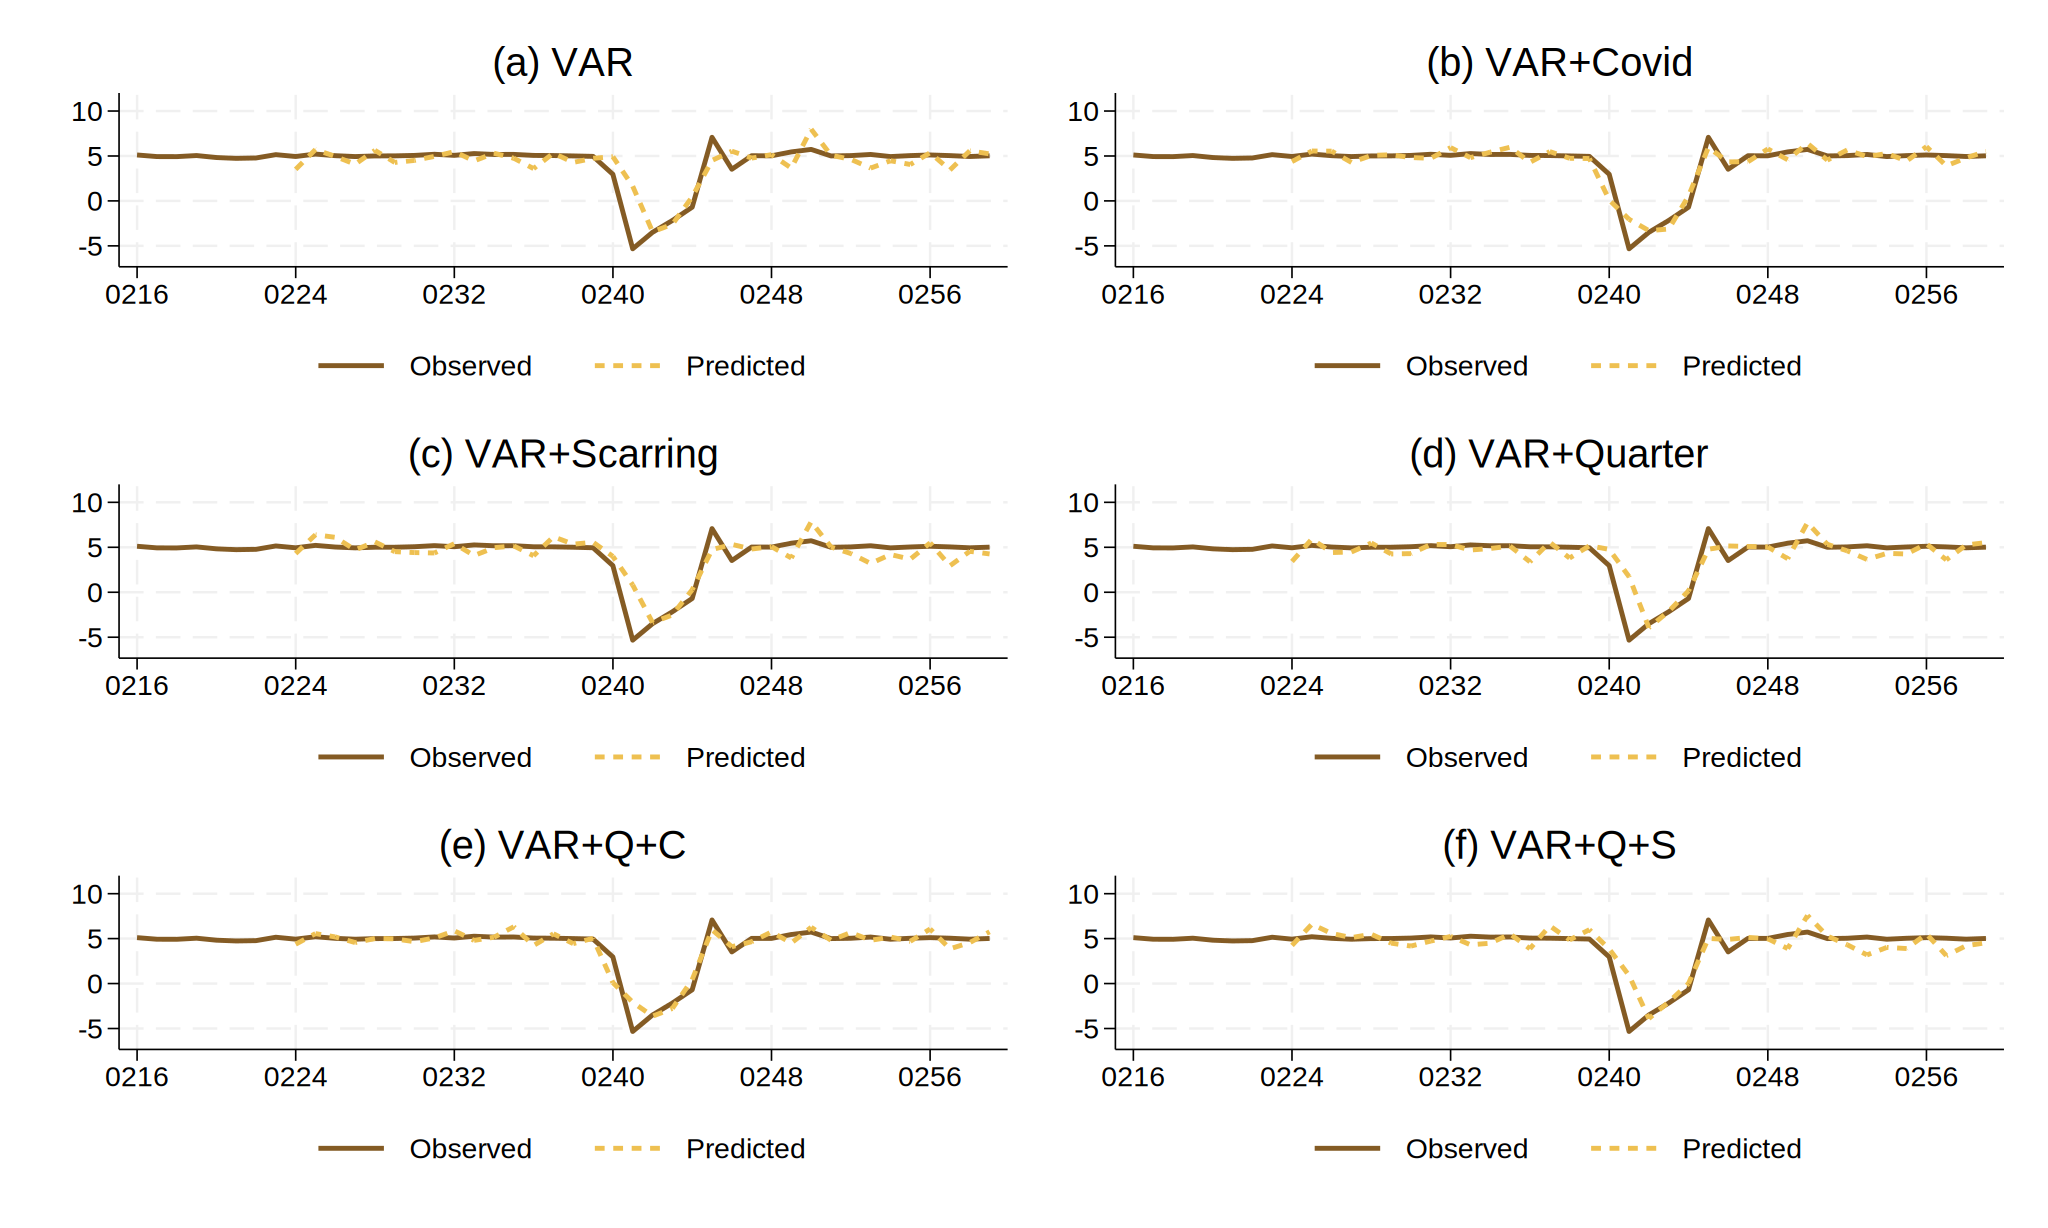

In [11]:
%%stata
var g ntlg, lags(1/8)
predict r_g
tsline g r_g, xtitle("") title("(a) VAR") lcolor("#845B24" "#EEC051") lpattern(solid shortdash) xlabel(, format(%ty)) legend(order(1 "Observed" 2 "Predicted")) lwidth(0.6 0.6)
graph save g1.gph, replace
var g ntlg, lags(1/8) exog(covid)
drop r_g
predict r_g
tsline g r_g, xtitle("") title("(b) VAR+Covid") lcolor("#845B24" "#EEC051") lpattern(solid shortdash) xlabel(, format(%ty)) legend(order(1 "Observed" 2 "Predicted")) lwidth(0.6 0.6)
graph save g2.gph, replace
var g ntlg, lags(1/8) exog(scar)
drop r_g
predict r_g
tsline g r_g, xtitle("") title("(c) VAR+Scarring") lcolor("#845B24" "#EEC051") lpattern(solid shortdash) xlabel(, format(%ty)) legend(order(1 "Observed" 2 "Predicted")) lwidth(0.6 0.6)
graph save g3.gph, replace
var g ntlg, lags(1/8) exog(q1 q2 q3)
drop r_g
predict r_g
tsline g r_g, xtitle("") title("(d) VAR+Quarter") lcolor("#845B24" "#EEC051") lpattern(solid shortdash) xlabel(, format(%ty)) legend(order(1 "Observed" 2 "Predicted")) lwidth(0.6 0.6)
graph save g4.gph, replace
var g ntlg, lags(1/8) exog(q1 q2 q3 covid)
drop r_g
predict r_g
tsline g r_g, xtitle("") title("(e) VAR+Q+C") lcolor("#845B24" "#EEC051") lpattern(solid shortdash) xlabel(, format(%ty)) legend(order(1 "Observed" 2 "Predicted")) lwidth(0.6 0.6)
graph save g5.gph, replace
var g ntlg, lags(1/8) exog(q1 q2 q3 scar)
drop r_g
predict r_g
tsline g r_g, xtitle("") title("(f) VAR+Q+S") lcolor("#845B24" "#EEC051") lpattern(solid shortdash) xlabel(, format(%ty)) legend(order(1 "Observed" 2 "Predicted")) lwidth(0.6 0.6)
graph save g6.gph, replace

graph combine g1.gph g2.gph g3.gph g4.gph g5.gph g6.gph, rows(3) cols(2) imargin(2 2 2 2)
graph export "fig/VARstata.png", width(2400) height(3200) replace


### ARDL with growth dataset

c:\Users\imed\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: q2, q3, q1.
  return _format_order(self.data.orig_exog, order, self._causal)
c:\Users\imed\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ntlg, q2, q1, q3.
  return _format_order(self.data.orig_exog, order, self._causal)
c:\Users\imed\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ntlg, q3.
  return _format_order(self.data.orig_exog, order, self._causal)


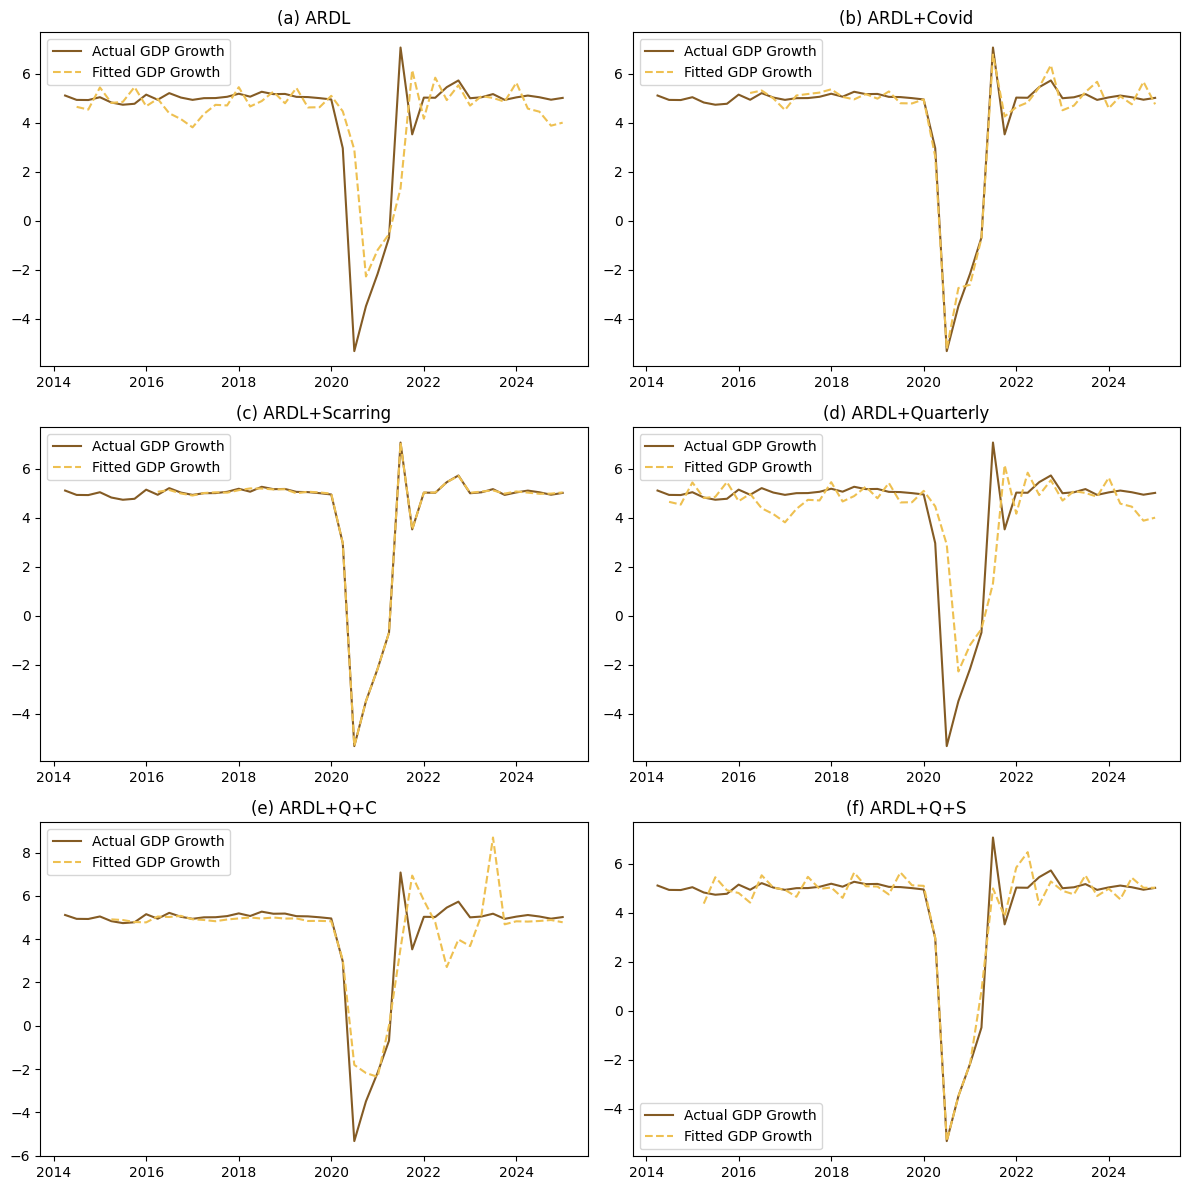

In [12]:

## ARDL with growth

en=ntl[['g']]
ex=ntl[['ntlg']]
exc=ntl[['ntlg','covid']]
exs=ntl[['ntlg','scar']]
exq=ntl[['ntlg','q1','q2','q3']]
exqc=ntl[['ntlg','q1','q2','q3','covid']]
exqs=ntl[['ntlg','q1','q2','q3','scar']]

lags = ardl_select_order(endog=en, exog=ex, maxlag=8,maxorder=8, ic='aic',seasonal=False)
ve = ARDL(endog=en,lags=lags.ar_lags,exog=ex,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exc, maxlag=8,maxorder=8, ic='aic',seasonal=False)
vec= ARDL(endog=en,lags=lags.ar_lags,exog=exc,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exs, maxlag=8,maxorder=8, ic='aic',seasonal=False)
ves= ARDL(endog=en,lags=lags.ar_lags,exog=exs,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exq, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veq= ARDL(endog=en,lags=lags.ar_lags,exog=exq,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exqc, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veqc= ARDL(endog=en,lags=lags.ar_lags,exog=exqc,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exqs, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veqs= ARDL(endog=en,lags=lags.ar_lags,exog=exqs,order=lags.dl_lags,trend='ct').fit()

models = {'fve': ve, 'fvec': vec,'fves': ves}
results = {}

for name, model in models.items():
    fitted = pd.DataFrame(model.predict(), columns=en.columns)
    fitted.index = pd.date_range(end='2024-12-31', periods=44, freq='QE')
    merged = pd.merge(en, fitted, left_index=True, right_index=True, suffixes=('', f'_fitted'))
    results[name] = merged

models = {'fveq': veq,'fveqc': veqc, 'fveqs': veqs}
result = {}

for name, model in models.items():
    fitted = pd.DataFrame(model.predict(), columns=en.columns)
    fitted.index = pd.date_range(end='2024-12-31', periods=44, freq='QE')
    merged = pd.merge(en, fitted, left_index=True, right_index=True, suffixes=('', f'_fitted'))
    result[name] = merged



fig, ax = plt.subplots(3,2,figsize=(12, 12))

ax[0,0].plot(results['fve']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[0,0].plot(results['fve']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[0,0].set_title('(a) ARDL')
ax[0,0].legend()

ax[0,1].plot(results['fvec']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[0,1].plot(results['fvec']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[0,1].set_title('(b) ARDL+Covid')
ax[0,1].legend()

ax[1,0].plot(results['fves']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[1,0].plot(results['fves']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[1,0].set_title('(c) ARDL+Scarring')
ax[1,0].legend()

ax[1,1].plot(result['fveq']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[1,1].plot(result['fveq']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[1,1].set_title('(d) ARDL+Quarterly')
ax[1,1].legend()

ax[2,0].plot(result['fveqc']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[2,0].plot(result['fveqc']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[2,0].set_title('(e) ARDL+Q+C')
ax[2,0].legend()

ax[2,1].plot(result['fveqs']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[2,1].plot(result['fveqs']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[2,1].set_title('(f) ARDL+Q+S')
ax[2,1].legend()
plt.tight_layout()
plt.savefig("fig/ARDL.png")
plt.show()



In [13]:
print(ves.summary())

                              ARDL Model Results                              
Dep. Variable:                      g   No. Observations:                   44
Model:                  ARDL(7, 8, 5)   Log Likelihood                  61.267
Method:               Conditional MLE   S.D. of innovations              0.046
Date:                Wed, 01 Oct 2025   AIC                            -72.534
Time:                        22:03:15   BIC                            -32.261
Sample:                    03-31-2016   HQIC                           -58.336
                         - 12-31-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0042      0.122     57.419      0.000       6.741       7.268
trend         -0.0058      0.005     -1.242      0.236      -0.016       0.004
g.L1          -0.3732      0.022    -17.270      0.0

### OLS Regression

## Quarterly Real GDP vs Quarterly NTL.

### Dataset

turn on the last line to see the dataframe.

In [14]:
## Data prep
### Creating data
ntl=pd.read_csv('ntl_monthly_avg_2012-2024.csv')
gdp=pd.read_excel('GDP_YoY_Quarterly_12_24.xlsx')

### Make time index
ntl.Date=pd.to_datetime(ntl['Date'])
ntl['qtr']=ntl['Date'].dt.quarter
ntl['year']=ntl['Date'].dt.year
### Averaging the radiance into quarterly, make it yoy quarterly growth
ntl=ntl.groupby(['year','qtr'])['NTL_Radiance'].mean().reset_index()
ntl['Date']=pd.date_range(start='2012-01-01', periods=len(ntl), freq='QE')
ntl=ntl[['Date','NTL_Radiance']]
ntl['g']=np.log(gdp['GDP'])
ntl['ntlg']=np.log(ntl['NTL_Radiance'])
#ntl['NTL_Radiancelag'] = ntl['NTL_Radiance'].shift(4)
#ntl['ntlg'] = ((ntl['NTL_Radiance'] - ntl['NTL_Radiancelag']) / ntl['NTL_Radiancelag']) * 100
### Creating dummy quarterly and dummy covid
ntl['q1']=np.where(ntl['Date'].dt.quarter==1,1,0)
ntl['q2']=np.where(ntl['Date'].dt.quarter==2,1,0)
ntl['q3']=np.where(ntl['Date'].dt.quarter==3,1,0)
ntl['q4']=np.where(ntl['Date'].dt.quarter==4,1,0)
ntl['covid']=np.where((ntl['Date'].dt.year>=2020) & (ntl['Date'].dt.year<=2022),1,0)
ntl['scar']=np.where((ntl['Date'].dt.year>=2020) ,1,0)
### Back to making time index
ntl=ntl.dropna().reset_index(drop=True)
ntl=ntl.set_index('Date')
ntl=ntl.asfreq('QE-DEC')
#ntlm=ntlm[['g','ntlg']]

### Creating dummy quarterly and dummy covid

## OLS-ing
mod=sm.OLS(ntl['g'], sm.add_constant(ntl['ntlg'])).fit()
ntl['resid']=mod.resid
ntl['ols']=mod.predict()
#ntl

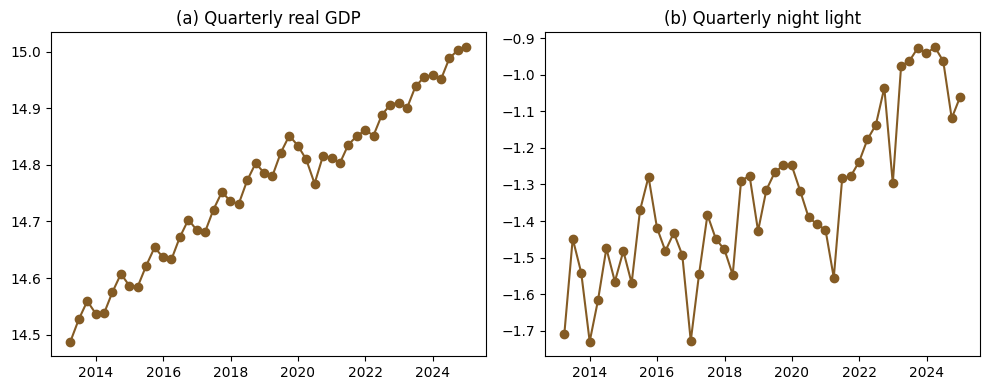

In [15]:
# Plotting GDP Growth and Night light growth side by side

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ntlm=ntl[4:]
ax1.plot(ntlm['g'],color='#845B24',marker='o', linestyle='-')
ax1.set_title('(a) Quarterly real GDP')

ax2.plot(ntlm['ntlg'], linestyle='-', color='#845B24',marker='o')
ax2.set_title('(b) Quarterly night light')

plt.tight_layout()
plt.savefig("fig/figQ.png") # Turn off to not save, or change file name to save in your preferred location
plt.show()



### OLS and residuals

                            OLS Regression Results                            
Dep. Variable:                      g   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     139.9
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           4.20e-16
Time:                        22:03:16   Log-Likelihood:                 57.804
No. Observations:                  52   AIC:                            -111.6
Df Residuals:                      50   BIC:                            -107.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.4614      0.062    250.049      0.0

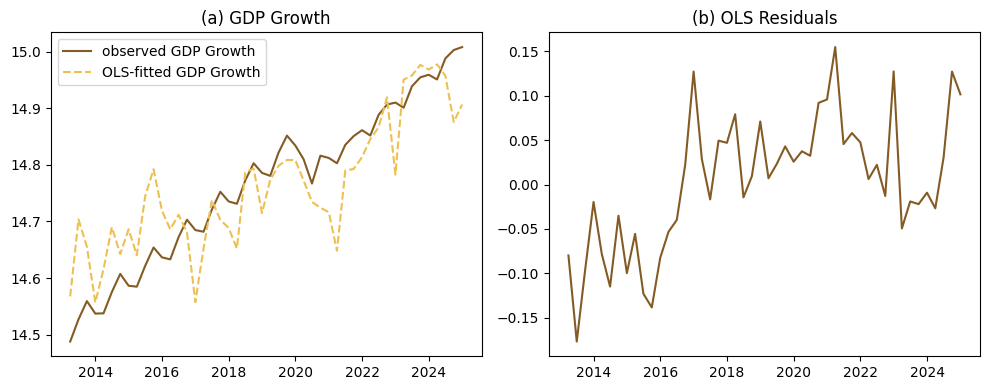

In [16]:
## OLS results and plotting residuals
ntl=ntlm
print(mod.summary())
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.plot(ntlm['g'],color='#845B24',linestyle="-",label="observed GDP Growth")
ax1.plot(ntlm['ols'],color='#EEC051',linestyle="--",label="OLS-fitted GDP Growth")
ax1.set_title('(a) GDP Growth')
ax1.legend()

ax2.plot(ntlm['resid'], linestyle='-', color='#845B24')
ax2.set_title('(b) OLS Residuals')

plt.tight_layout()
plt.savefig("fig/Qols.png") # Turn off to not save, or change file name to save in your preferred location
plt.show()

### ADF test of the series and residuals.

We don't first diff in this step cuz we do another ADF test on the growth dataset.

In [17]:
## ADF Test for g, ntlg and OLS residuals
def adf_test(series, name=""):
    """
    Perform ADF test and print results
    """
    result = adfuller(series.dropna(), autolag="BIC")
    print(f"ADF Test for {name}")
    print(f"  Test Statistic : {result[0]:.4f}")
    print(f"  p-value        : {result[1]:.4f}")
    print(f"  #Lags Used     : {result[2]}")
    print(f"  #Observations  : {result[3]}")
    for key, value in result[4].items():
        print(f"   Critical Value {key} : {value:.4f}")
    if result[1] <= 0.05:
        print(f"  ==> {name} is stationary\n (reject H0 of unit root)\n")
    else:
        print(f"  ==> {name} is non-stationary\n (fail to reject H0)\n")

# Run ADF tests for both series
adf_test(ntlm["g"], "GDP YoY Growth")
adf_test(ntlm["ntlg"], "NTL YoY Growth")
adf_test(ntlm["resid"], "OLS Residuals")

ADF Test for GDP YoY Growth
  Test Statistic : -0.4807
  p-value        : 0.8957
  #Lags Used     : 4
  #Observations  : 43
   Critical Value 1% : -3.5925
   Critical Value 5% : -2.9315
   Critical Value 10% : -2.6041
  ==> GDP YoY Growth is non-stationary
 (fail to reject H0)

ADF Test for NTL YoY Growth
  Test Statistic : -2.3235
  p-value        : 0.1645
  #Lags Used     : 0
  #Observations  : 47
   Critical Value 1% : -3.5778
   Critical Value 5% : -2.9253
   Critical Value 10% : -2.6008
  ==> NTL YoY Growth is non-stationary
 (fail to reject H0)

ADF Test for OLS Residuals
  Test Statistic : -3.1182
  p-value        : 0.0252
  #Lags Used     : 0
  #Observations  : 47
   Critical Value 1% : -3.5778
   Critical Value 5% : -2.9253
   Critical Value 10% : -2.6008
  ==> OLS Residuals is stationary
 (reject H0 of unit root)



### Johansen cointegration test

In [18]:
# Select optimal lag order
ntlm=ntl[['g','ntlg']]
lag_order = select_order(ntlm, maxlags=12, deterministic="ci")
print(lag_order.summary())

# Select cointegration rank
coint_rank = select_coint_rank(ntlm, det_order=0, k_ar_diff=lag_order.bic)
print(coint_rank.summary())

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -11.94     -11.58*   6.547e-06      -11.82
1       -11.86      -11.33   7.124e-06      -11.67
2       -12.00      -11.29   6.265e-06      -11.75
3      -12.42*      -11.53  4.188e-06*     -12.11*
4       -12.27      -11.20   4.989e-06      -11.90
5       -12.12      -10.88   5.971e-06      -11.69
6       -12.11      -10.69   6.377e-06      -11.62
7       -12.18      -10.58   6.353e-06      -11.63
8       -12.19      -10.42   6.919e-06      -11.58
9       -12.27      -10.31   7.310e-06      -11.59
10      -12.22      -10.09   9.146e-06      -11.48
11      -12.09      -9.782   1.318e-05      -11.30
12      -12.34      -9.849   1.448e-05      -11.48
--------------------------------------------------
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------

### VECM with quarterly dataset

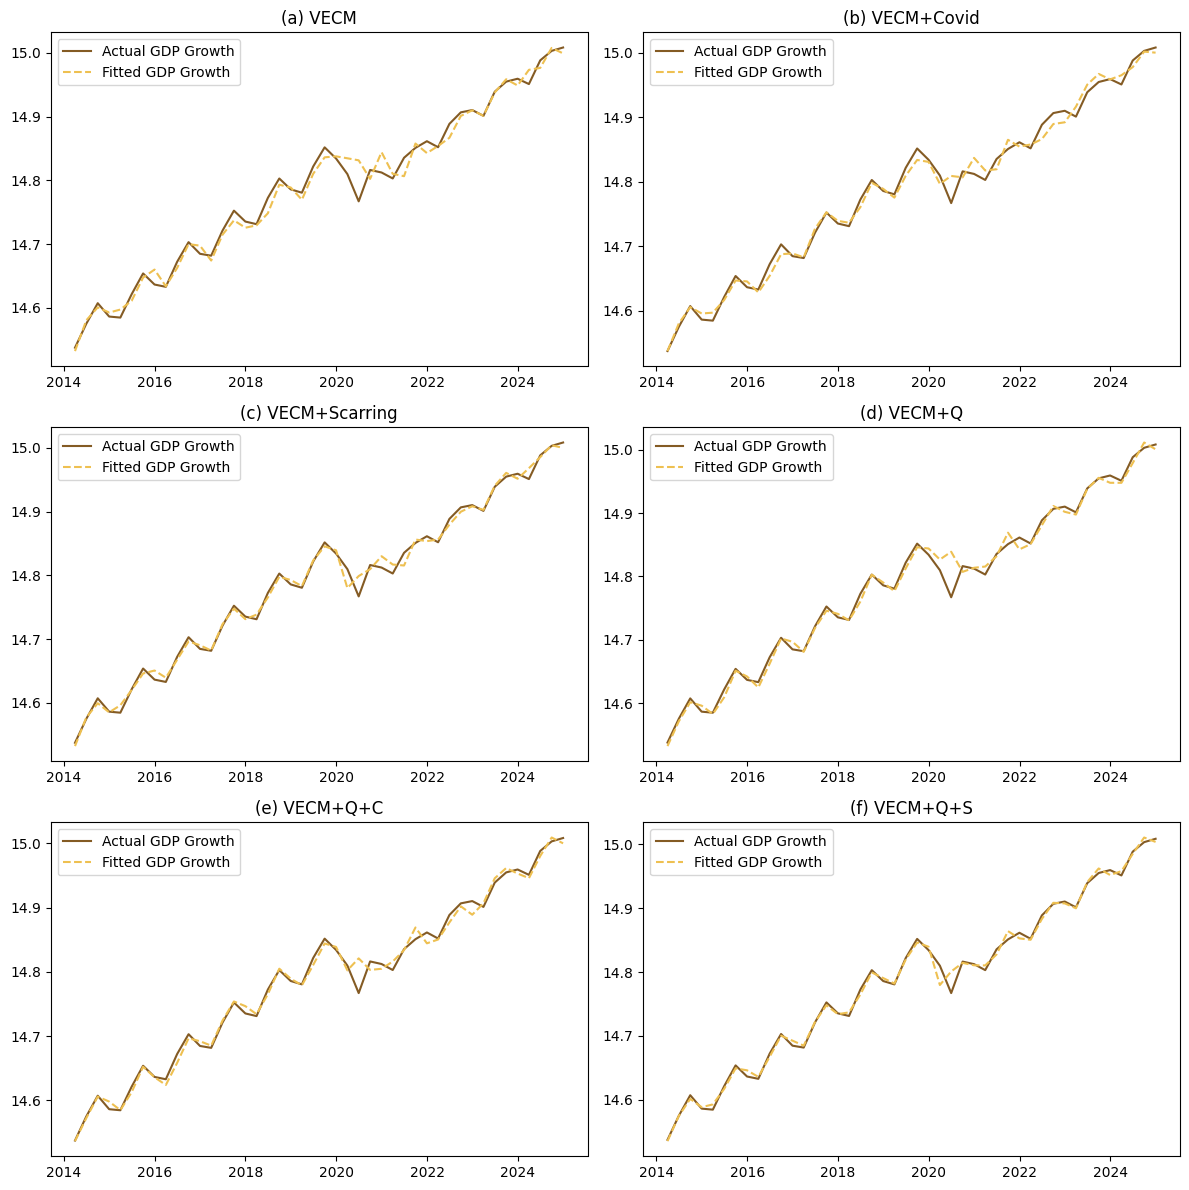

In [19]:
en=ntl[['g','ntlg']]
exc=ntl[['covid']]
exs=ntl[['scar']]
exq=ntl[['q1','q2','q3']]
exqc=ntl[['q1','q2','q3','covid']]
exqs=ntl[['q1','q2','q3','scar']]

lag=lag_order.aic

ve = VECM(en,k_ar_diff=lag, coint_rank=1, deterministic="cili").fit()
vec = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exc,deterministic="cili").fit()
ves = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exs,deterministic="cili").fit()
veq = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exq,deterministic="cili").fit()
veqc = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exqc,deterministic="cili").fit()
veqs = VECM(en,k_ar_diff=lag, coint_rank=1, exog=exqs,deterministic="cili").fit()

models = {'fve': ve, 'fvec': vec,'fves': ves, 'fveq': veq,'fveqc': veqc, 'fveqs': veqs}
results = {}

for name, model in models.items():
    fitted = pd.DataFrame(model.fittedvalues, columns=en.columns)
    fitted.index = pd.date_range(end='2024-12-31', periods=44, freq='QE')
    merged = pd.merge(en, fitted, left_index=True, right_index=True, suffixes=('', f'_fitted'))
    results[name] = merged


fig, ax = plt.subplots(3,2,figsize=(12, 12))

ax[0,0].plot(results['fve']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[0,0].plot(results['fve']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[0,0].set_title('(a) VECM')
ax[0,0].legend()

ax[0,1].plot(results['fvec']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[0,1].plot(results['fvec']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[0,1].set_title('(b) VECM+Covid')
ax[0,1].legend()

ax[1,0].plot(results['fves']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[1,0].plot(results['fves']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[1,0].set_title('(c) VECM+Scarring')
ax[1,0].legend()

ax[1,1].plot(results['fveq']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[1,1].plot(results['fveq']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[1,1].set_title('(d) VECM+Q')
ax[1,1].legend()

ax[2,0].plot(results['fveqc']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[2,0].plot(results['fveqc']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[2,0].set_title('(e) VECM+Q+C')
ax[2,0].legend()

ax[2,1].plot(results['fveqs']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[2,1].plot(results['fveqs']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[2,1].set_title('(f) VECM+Q+S')
ax[2,1].legend()
plt.tight_layout()
plt.savefig("fig/VECMQ.png")
plt.show()

In [20]:
print(veqs.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation g
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog1         -0.0101      0.005     -1.860      0.063      -0.021       0.001
exog2          0.0065      0.006      1.120      0.263      -0.005       0.018
exog3          0.0180      0.004      4.128      0.000       0.009       0.026
exog4         -0.0596      0.007     -7.979      0.000      -0.074      -0.045
L1.g          -0.1187      0.079     -1.505      0.132      -0.273       0.036
L1.ntlg        0.0075      0.014      0.546      0.585      -0.019       0.034
L2.g          -0.0404      0.088     -0.461      0.645      -0.212       0.131
L2.ntlg       -0.0192      0.016     -1.165      0.244      -0.052       0.013
L3.g          -0.0434      0.107     -0.407      0.684      -0.252       0.166
L3.ntlg       -0.0229      0.015     -1.500      0

## ARDL with quarterly dataset

c:\Users\imed\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ntlg.
  return _format_order(self.data.orig_exog, order, self._causal)
c:\Users\imed\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: q1.
  return _format_order(self.data.orig_exog, order, self._causal)
c:\Users\imed\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ntlg, q1.
  return _format_order(self.data.orig_exog, order, self._causal)
c:\Users\imed\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variab

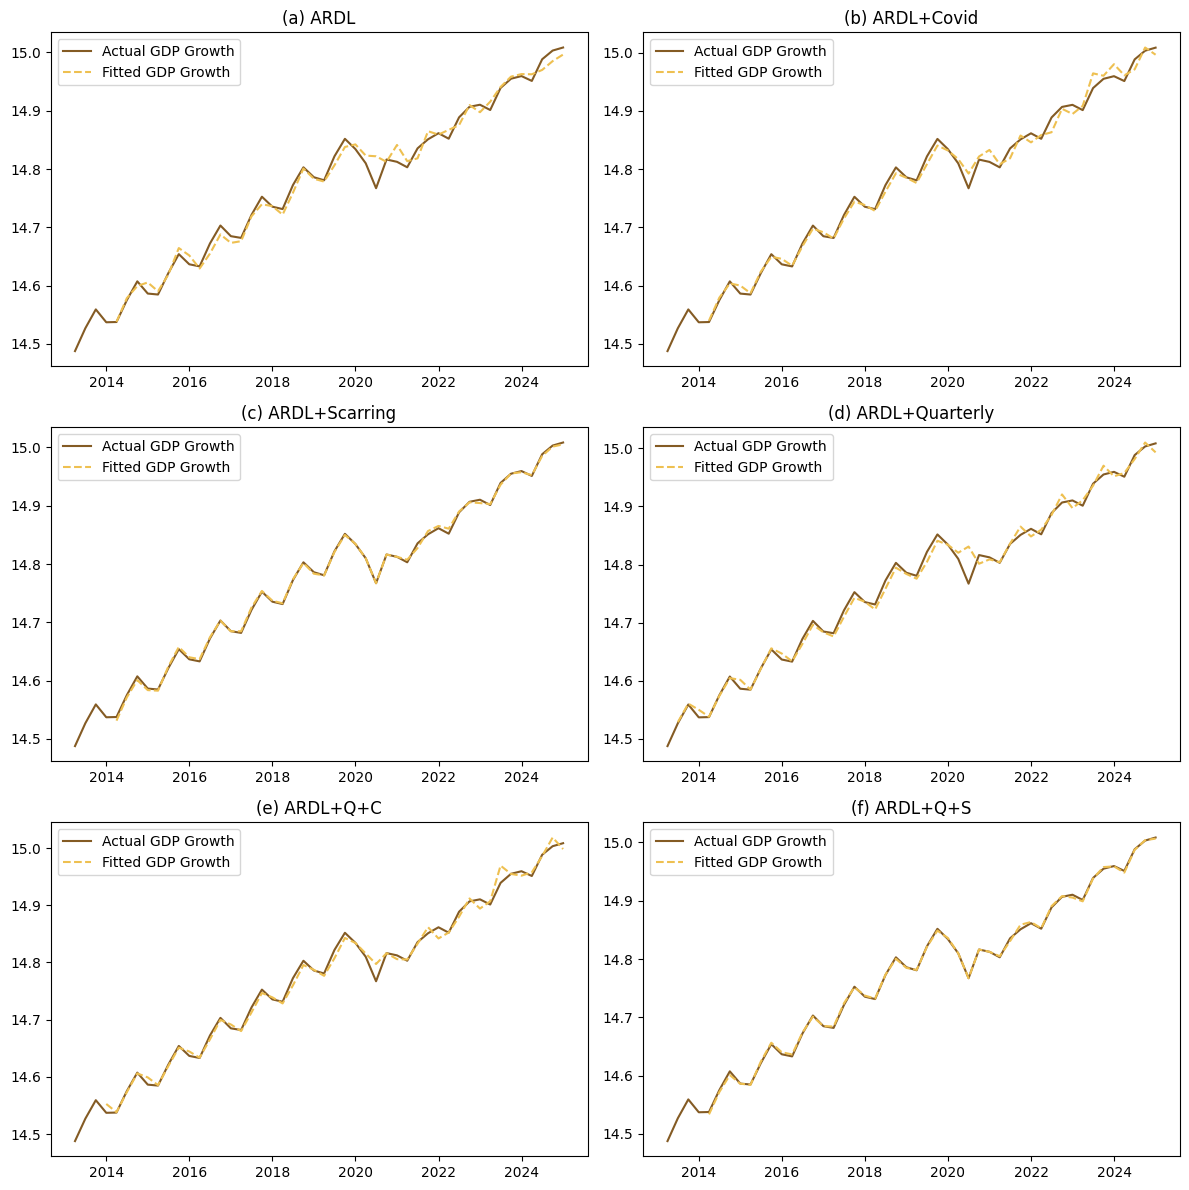

In [21]:
en=ntl[['g']]
ex=ntl[['ntlg']]
exc=ntl[['ntlg','covid']]
exs=ntl[['ntlg','scar']]
exq=ntl[['ntlg','q1','q2','q3']]
exqc=ntl[['ntlg','q1','q2','q3','covid']]
exqs=ntl[['ntlg','q1','q2','q3','scar']]

lags = ardl_select_order(endog=en, exog=ex, maxlag=4,maxorder=4, ic='aic',seasonal=False)
ve = ARDL(endog=en,lags=lags.ar_lags,exog=ex,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exc, maxlag=4,maxorder=4, ic='aic',seasonal=False)
vec= ARDL(endog=en,lags=lags.ar_lags,exog=exc,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exs, maxlag=4,maxorder=4, ic='aic',seasonal=False)
ves= ARDL(endog=en,lags=lags.ar_lags,exog=exs,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exq, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veq= ARDL(endog=en,lags=lags.ar_lags,exog=exq,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exqc, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veqc= ARDL(endog=en,lags=lags.ar_lags,exog=exqc,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exqs, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veqs= ARDL(endog=en,lags=lags.ar_lags,exog=exqs,order=lags.dl_lags,trend='ct').fit() # This looks too good to be true

models = {'fve': ve, 'fvec': vec,'fves': ves, 'fveq': veq,'fveqc': veqc, 'fveqs': veqs}
results = {}

for name, model in models.items():
    fitted = pd.DataFrame(model.predict(), columns=en.columns)
    fitted.index = pd.date_range(end='2024-12-31', periods=48, freq='QE')
    merged = pd.merge(en, fitted, left_index=True, right_index=True, suffixes=('', f'_fitted'))
    results[name] = merged


fig, ax = plt.subplots(3,2,figsize=(12, 12))

ax[0,0].plot(results['fve']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[0,0].plot(results['fve']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[0,0].set_title('(a) ARDL')
ax[0,0].legend()

ax[0,1].plot(results['fvec']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[0,1].plot(results['fvec']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[0,1].set_title('(b) ARDL+Covid')
ax[0,1].legend()

ax[1,0].plot(results['fves']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[1,0].plot(results['fves']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[1,0].set_title('(c) ARDL+Scarring')
ax[1,0].legend()

ax[1,1].plot(results['fveq']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[1,1].plot(results['fveq']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[1,1].set_title('(d) ARDL+Quarterly')
ax[1,1].legend()

ax[2,0].plot(results['fveqc']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[2,0].plot(results['fveqc']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[2,0].set_title('(e) ARDL+Q+C')
ax[2,0].legend()

ax[2,1].plot(results['fveqs']['g'],color='#845B24',linestyle='-',label="Actual GDP Growth")
ax[2,1].plot(results['fveqs']['g_fitted'], linestyle='--', color='#EEC051', label="Fitted GDP Growth")
ax[2,1].set_title('(f) ARDL+Q+S')
ax[2,1].legend()
plt.tight_layout()
plt.savefig("fig/ARDLQ.png") # Turn off to not save, or change file name to save in your preferred location
plt.show()

In [22]:
print(veqs.summary())

                               ARDL Model Results                              
Dep. Variable:                       g   No. Observations:                   48
Model:             ARDL(4, 0, 0, 0, 4)   Log Likelihood                 199.333
Method:                Conditional MLE   S.D. of innovations              0.003
Date:                 Wed, 01 Oct 2025   AIC                           -368.665
Time:                         22:03:23   BIC                           -341.902
Sample:                     03-31-2014   HQIC                          -358.740
                          - 12-31-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.5332      5.680      6.960      0.000      27.932      51.134
trend          0.0335      0.005      6.926      0.000       0.024       0.043
g.L1          -0.6836      0.122     -5.583 